In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


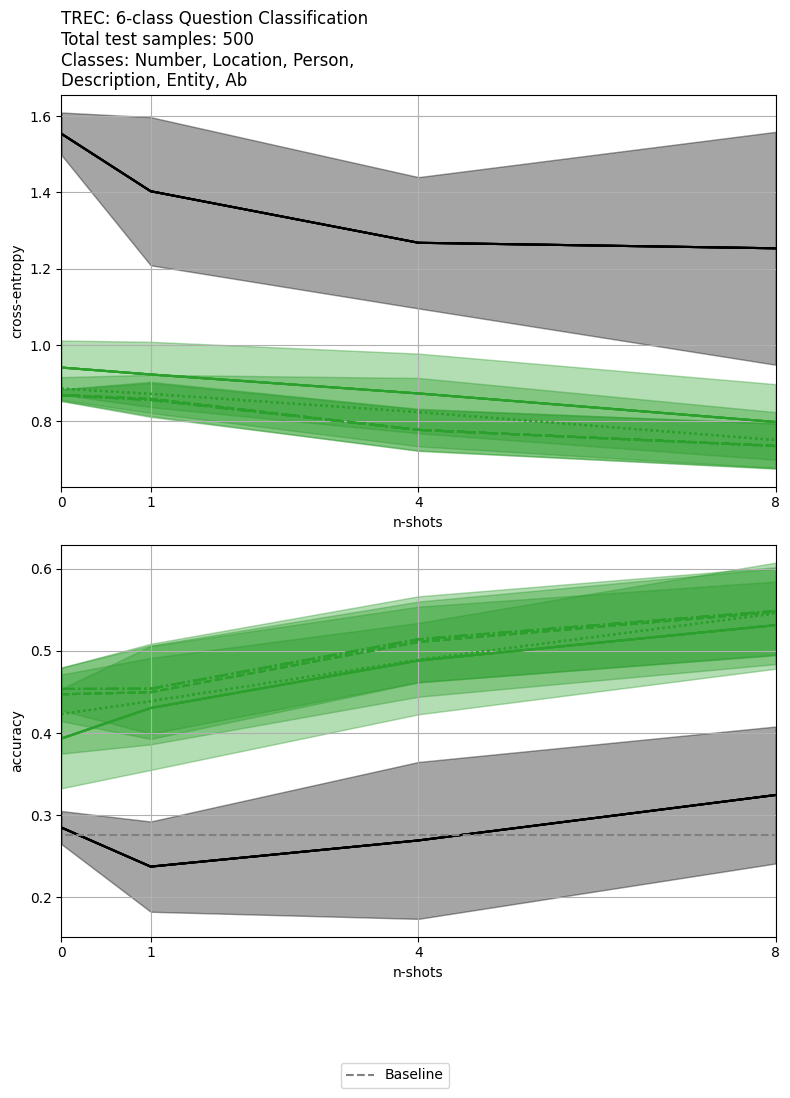

In [30]:
def plot_results(results, plot_original=True, num_samples=[50, 100], plot_cf=True, plot_peaky=False, plot_xval=False):
    dfs_result = []
    if plot_original:
        df = results[results["prob_type"] == "test_probs_original"].copy()
        df["prob_type"] = "Original"
        dfs_result.append(df)
    if plot_peaky:
        df = results[results["prob_type"] == "test_probs_cal_peaky"].copy()
        df["prob_type"] = "Calibrated Train-on-Test"
        dfs_result.append(df)
    if plot_xval:
        df = results[results["prob_type"] == "test_probs_cal_xval"].copy()
        df["prob_type"] = "Calibrated Cross-Validation"
        dfs_result.append(df)
    if plot_cf:
        all_cf_prob_types = [pt.split("reest_cf")[-1] for pt in results.prob_type.unique() if "reest_cf" in pt]
        for cf_prob_type in all_cf_prob_types:
            df = results[results["prob_type"] == f"test_probs_reest_cf_{cf_prob_type}"].copy()
            df["prob_type"] = f"{cf_prob_type} Content-Free"
            dfs_result.append(df)
    for n in num_samples:
        df = results[results["prob_type"] == f"test_probs_cal_train_{n}"].copy()
        df["prob_type"] = f"Calibrated Train-on-Held-Out ({n})"
        dfs_result.append(df)

    def result2kwargs(result):
        if result == "Original":
            kwargs = {"color": "black", "linestyle": "-"}
        elif result == "Calibrated Train-on-Test":
            kwargs = {"color": "tab:blue", "linestyle": "-"}
        elif result == "Calibrated Cross-Validation":
            kwargs = {"color": "tab:orange", "linestyle": "-"}
        for num, ls in zip([50, 100, 400, 600],["-", ":", "--", "-."]):
            if result == f"Calibrated Train-on-Held-Out ({num})":
                kwargs = {"color": "tab:green", "linestyle": ls}
                break
        for cf, ls in zip(["idk", "mask_na_none"],["-", ":"]):
            if result == f"{cf} Content-Free":
                kwargs = {"color": "tab:red", "linestyle": ls}
                break
        return kwargs
        
    df_results = pd.concat(dfs_result)
    metrics = [c.split("score:")[-1] for c in df_results.columns if "score:" in c]
    datasets = df.dataset.unique()
    # df_results.drop(columns=["model"], inplace=True)
    df_results = df_results.groupby(["dataset", "n_shots", "prob_type"]).agg(
        {f"score:{metric}": ["mean", "std"] for metric in metrics}
    )
    from src.utils import dataset2baseline, dataset2description

    fig, ax = plt.subplots(len(metrics), len(datasets), figsize=(8, 10))
    if len(metrics) == 1 and len(datasets) == 1:
        ax = np.array([[ax]])
    elif len(metrics) == 1:
        ax = ax.reshape(1, -1)
    elif len(datasets) == 1:
        ax = ax.reshape(-1, 1)

    for i, metric in enumerate(metrics):
        for j, dataset in enumerate(datasets):
            # Plot acc vs nshots for each output_prob_type
            for result in df_results.index.get_level_values("prob_type"):
                # if result not in df_results:
                #     continue
                mean = df_results.loc[(dataset, slice(None), result), (f"score:{metric}", "mean")]
                std = df_results.loc[(dataset, slice(None), result), (f"score:{metric}", "std")]
                n_shots = mean.index.get_level_values("n_shots")
                kwargs = result2kwargs(result)
                ax[i,j].plot(n_shots, mean, **kwargs)
                ax[i,j].fill_between(n_shots, mean - std, mean + std, alpha=0.1, color=kwargs["color"])
            if i == 0:
                ax[i,j].set_title(dataset2description(dataset),ha='left', x=0.0)
            if metric == "accuracy":
                ax[i,j].hlines(dataset2baseline(dataset), n_shots[0]-1, n_shots[-1]+1, linestyles="dashed", colors="gray", label="Baseline")
            ax[i,j].set_xlabel("n-shots")
            ax[i,j].set_xticks(n_shots)
            ax[i,j].set_ylabel(metric)
            ax[i, j].set_xlim([n_shots[0], n_shots[-1]])
            ax[i,j].grid()
    
    # add legend
    handles, labels = ax[i,j].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=max([len(results),1]), bbox_to_anchor=(0.5, -0.1))
    fig.tight_layout()

experiment = "gpt2-xl_trec_sst2_agnews_dbpedia"
calibration_config = "logloss_noscale_100boots"
results = pd.read_csv(f"results/{experiment}_{calibration_config}.csv")
plot_results(results, plot_original=True, num_samples=[50, 100, 400, 600], plot_cf=True, plot_peaky=False, plot_xval=False)